In [1]:
import pandas
import os
import numpy as np


df = pandas.read_csv("1335.vdb.tab", sep="\t", header =None) 
#Récupère la liste de nombre, correspondant aux comptage des différents espèces en fonction des lieu de prélevement
#2=door_in_1 ; 3=door_in_2 ; 4=faucet_handle_1 ; 5=faucet_handle_2 ; 6=sink_floor_1 ; 7=sink_floor_2
#8=soap_dispenser_1 ; 9=stall_in_1 ; 10=toilet_floor_1 ; 11=toilet_floor_1 ; 12=toilet_flush_handle_1
#13=toilet_flush_handle_2 ; 14=toilet_seat_1 ; 15=toilet_seat_2
def getcountsfromrow(row):
    l_l = [ int(row[2]),
            int(row[3]),
            int(row[4]),
            int(row[5]),
            int(row[6]),
            int(row[7]),
            int(row[8]),
            int(row[9]),
            int(row[10]),
            int(row[11]),
            int(row[12]),
            int(row[13]),
            int(row[14]),
            int(row[15]) ]
    return l_l

"""
Code pour generer dictionnaire. 

Sous forme { name : "nomDeLaTaxo", 
count : list de compte pour chaque localisation, 
children : liste des niveau plus précis venant de cette taxo}

Au prealable, avec cat 1335.vdb.tab | cut -f 2 | cut -d ";" -f 1 | uniq
OTUConTaxonomy"Bacteria(100)  => on a confirmé que ce sont toutes Bacteria
"""
def getDicoTaxo(df):
    dicotaxo = { "name" : "Bacteria", "count" : [0 for i in range(14)], "children" : []}
    for index,row in df.iterrows():
        leveltax = row[1].split(';')  # uniquement indexes >=1 m'interessent 
        if index > 0:
            COUNTS = getcountsfromrow(row)
            tmp5 = {}
            tmp4 = {}
            tmp3 = {}
            tmp2 = {}
            tmp1 = {}
            tmp5["name"] = leveltax[5]
            tmp4["name"] = leveltax[4]
            tmp3["name"] = leveltax[3]
            tmp2["name"] = leveltax[2]
            tmp1["name"] = leveltax[1]      
            tmp5["count"] =  getcountsfromrow(row)
            tmp5["children"] = []  # lowest level
            tmp4["count"] =  getcountsfromrow(row)
            tmp4["children"] = [tmp5]
            tmp3["count"] =  getcountsfromrow(row)
            tmp3["children"] = [tmp4]
            tmp2["count"] =  getcountsfromrow(row)
            tmp2["children"] = [tmp3]
            tmp1["count"] = getcountsfromrow(row)
            tmp1["children"] = [tmp2]
            tmpcounts = dicotaxo["count"]
            dicotaxo["count"] = np.add(tmpcounts, COUNTS)
            if leveltax[1] not in [m["name"] for m in dicotaxo["children"]] :
                dicotaxo["children"].append(tmp1)
            else:
                for m in dicotaxo["children"]:
                    if m["name"] == leveltax[1]:
                        tmpc = m["count"]
                        m["count"] = np.add(tmpc, COUNTS)
                        if leveltax[2] not in [n["name"] for n in m["children"]] :
                            m["children"].append(tmp2)
                        else:
                            for n in m["children"]:
                                if n["name"] == leveltax[2]:
                                    tmpc = n["count"]
                                    n["count"] = np.add(tmpc, COUNTS)
                                    if leveltax[3] not in [o["name"] for o in n["children"]]:
                                        n["children"].append(tmp3)
                                    else: 
                                        for o in n["children"]:
                                            if o["name"] == leveltax[3]:
                                                tmpc = o["count"]
                                                o["count"] = np.add(tmpc,COUNTS)
                                                if leveltax[4] not in [p["name"] for p in o["children"]]:
                                                    o["children"].append(tmp4)
                                                else:
                                                    for p in o["children"]:
                                                        if p["name"] == leveltax[4]:
                                                            tmpc = p["count"]
                                                            p["count"] = np.add(tmpc, COUNTS)
                                                            if leveltax[5] not in [q["name"] for q in p["children"]]:
                                                                p["children"].append(tmp5)
                                                            else:
                                                                for q in p["children"]:
                                                                    if q["name"] == leveltax[5]:
                                                                        tmpc = q["count"]
                                                                        q["count"] = np.add(tmpc, COUNTS)
                                                                        q["children"] = []
                                                                        # this is the lowest level                                        
    return dicotaxo



In [2]:
"""
Méthodes pour récupérer des données intéréssantes du dicoTaxo en fonction de figure voulu
"""

#Méthode pour récupérer le niveau de taxo demander (convertie en chiffre)
def convertNiv(niveau):
    if niveau.upper() == "REGNE":
        return 1
    if niveau.upper() == "PHYLUM":
        return 2
    if niveau.upper() == "CLASSE":
        return 3
    if niveau.upper() == "ORDRE":
        return 4
    if niveau.upper() == "FAMILLE":
        return 5
    if niveau.upper() == "GENRE":
        return 6

#Permet créer un dico pour chaque niveau
def dicoListeNiveau(nomList, dico):
    dico[nomList] = []
    
"""
Méthode 1 : En fonction du niveaux de taxo récupéré donnne pour l'espèce le comptage en fonction du lieu
Input : niveau taxo Regne;Phylum;Classe;Ordre;Famille;Genre
Output : liste de vecteurs ; 1er : vecteur des espèces, 
puis 1 vecteurs par localisation (1 vecteur donne le comptage pour l'espèce dans la localisation donnée)
Ordre pour la localisation : "door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"
"""
def getNiv(niveau,dicoTaxo):
    niv = convertNiv(niveau)
    vecteurs = []
    dicoListeNivx = {}
    #Regne 
    listeRegne = []
    #Regne compte
    listelRegne = []
    #Autre niveau
    listePhylum =[]
    listeClasse =[]
    listeOrdre =[]
    listeFamille =[]
    listeGenre =[]
    #autre niveau compte
    for i in range(1,15):
        nomList = f"listel{i}" + niveau.lower()
        dicoListeNiveau(nomList,dicoListeNivx )

    for k1, v1 in dicoTaxo.items():
        #Récupère que pour le règne
        if k1 == "name" and niv == 1:
            listeRegne.append(v1)
            vecteurs.append(listeRegne)
        elif k1 == "count" and niv == 1:
            listelRegne.append(v1)
            vecteurs.append(listelRegne)
        elif k1 == "children" and niv > 1: 
            for phylum in dicoTaxo['children']:
                for k2, v2 in phylum.items():
                    #Récupère que pour le phylum
                    if k2 == "name" and niv == 2:
                        listePhylum.append(v2)
                    elif k2 == "count" and niv == 2:
                        for i in range(0,14):
                            numList = i+1
                            nomList = f"listel{numList}" + niveau.lower()
                            dicoListeNivx[nomList].append(v2[i])

                    #Descend dans les niveau plus précis
                    elif k2 == "children" and niv > 2:
                        for classe in v2:
                            for k3, v3 in classe.items():
                                #Récupère que pour la classe
                                if k3 == "name" and niv == 3:
                                    listeClasse.append(v3)
                                elif k3 == "count" and niv == 3:
                                     for i in range(0,14):
                                        numList = i+1
                                        nomList = f"listel{numList}" + niveau.lower()
                                        dicoListeNivx[nomList].append(v3[i])
                                #Descend dans les niveau plus précis
                                elif k3 == "children" and niv > 3:
                                    for ordre in v3:
                                        for k4, v4 in ordre.items():
                                            #Récupère que pour l'ordre
                                            if k4 == "name" and niv == 4:
                                                listeOrdre.append(v4)
                                            elif k4 == "count" and niv == 4:
                                                for i in range(0,14):
                                                    numList = i+1
                                                    nomList = f"listel{numList}" + niveau.lower()
                                                    dicoListeNivx[nomList].append(v4[i])
                                            #Descend dans les niveau plus précis
                                            elif k4 == "children" and niv > 4:
                                                for famille in v4:
                                                    for k5, v5 in famille.items():
                                                        #Récupère que pour la famille
                                                        if k5 == "name" and niv == 5:
                                                            listeFamille.append(v5)
                                                        elif k5 == "count" and niv == 5:
                                                            for i in range(0,14):
                                                                numList = i+1
                                                                nomList = f"listel{numList}" + niveau.lower()
                                                                dicoListeNivx[nomList].append(v5[i])
                                                        #Descend dans les niveau plus précis
                                                        elif k5 == "children" and niv > 5:
                                                            for genre in v5:
                                                                for k6, v6 in genre.items():
                                                                    #Récupère que pour la famille
                                                                    if k6 == "name" and niv == 6:
                                                                        listeGenre.append(v6)
                                                                    elif k6 == "count" and niv == 6:
                                                                        for i in range(0,14):
                                                                            numList = i+1
                                                                            nomList = f"listel{numList}" + niveau.lower()
                                                                            dicoListeNivx[nomList].append(v6[i])
                                                                    

    #Forme les vecteurs en fonction du niveau de taxo voulu.
    if niv == 2:
        vecteurs.append(listePhylum);vecteurs.append(dicoListeNivx['listel1phylum']);vecteurs.append(dicoListeNivx['listel2phylum']);vecteurs.append(dicoListeNivx['listel3phylum'])
        vecteurs.append(dicoListeNivx['listel4phylum']);vecteurs.append(dicoListeNivx['listel5phylum']);vecteurs.append(dicoListeNivx['listel6phylum']);vecteurs.append(dicoListeNivx['listel7phylum'])
        vecteurs.append(dicoListeNivx['listel8phylum']);vecteurs.append(dicoListeNivx['listel9phylum']);vecteurs.append(dicoListeNivx['listel10phylum']);vecteurs.append(dicoListeNivx['listel11phylum'])
        vecteurs.append(dicoListeNivx['listel12phylum']);vecteurs.append(dicoListeNivx['listel13phylum']);vecteurs.append(dicoListeNivx['listel14phylum']);
    if niv == 3:
        vecteurs.append(listeClasse);vecteurs.append(dicoListeNivx['listel1classe']);vecteurs.append(dicoListeNivx['listel2classe']);vecteurs.append(dicoListeNivx['listel3classe'])
        vecteurs.append(dicoListeNivx['listel4classe']);vecteurs.append(dicoListeNivx['listel5classe']);vecteurs.append(dicoListeNivx['listel6classe']);vecteurs.append(dicoListeNivx['listel7classe'])
        vecteurs.append(dicoListeNivx['listel8classe']);vecteurs.append(dicoListeNivx['listel9classe']);vecteurs.append(dicoListeNivx['listel10classe']);vecteurs.append(dicoListeNivx['listel11classe'])
        vecteurs.append(dicoListeNivx['listel12classe']);vecteurs.append(dicoListeNivx['listel13classe']);vecteurs.append(dicoListeNivx['listel14classe']);
    if niv == 4:
        vecteurs.append(listeOrdre);vecteurs.append(dicoListeNivx['listel1ordre']);vecteurs.append(dicoListeNivx['listel2ordre']);vecteurs.append(dicoListeNivx['listel3ordre'])
        vecteurs.append(dicoListeNivx['listel4ordre']);vecteurs.append(dicoListeNivx['listel5ordre']);vecteurs.append(dicoListeNivx['listel6ordre']);vecteurs.append(dicoListeNivx['listel7ordre'])
        vecteurs.append(dicoListeNivx['listel8ordre']);vecteurs.append(dicoListeNivx['listel9ordre']);vecteurs.append(dicoListeNivx['listel10ordre']);vecteurs.append(dicoListeNivx['listel11ordre'])
        vecteurs.append(dicoListeNivx['listel12ordre']);vecteurs.append(dicoListeNivx['listel13ordre']);vecteurs.append(dicoListeNivx['listel14ordre']);
    if niv == 5:
        vecteurs.append(listeFamille);vecteurs.append(dicoListeNivx['listel1famille']);vecteurs.append(dicoListeNivx['listel2famille']);vecteurs.append(dicoListeNivx['listel3famille'])
        vecteurs.append(dicoListeNivx['listel4famille']);vecteurs.append(dicoListeNivx['listel5famille']);vecteurs.append(dicoListeNivx['listel6famille']);vecteurs.append(dicoListeNivx['listel7famille'])
        vecteurs.append(dicoListeNivx['listel8famille']);vecteurs.append(dicoListeNivx['listel9famille']);vecteurs.append(dicoListeNivx['listel10famille']);vecteurs.append(dicoListeNivx['listel11famille'])
        vecteurs.append(dicoListeNivx['listel12famille']);vecteurs.append(dicoListeNivx['listel13famille']);vecteurs.append(dicoListeNivx['listel14famille']);
    if niv == 6:
        vecteurs.append(listeGenre);vecteurs.append(dicoListeNivx['listel1genre']);vecteurs.append(dicoListeNivx['listel2genre']);vecteurs.append(dicoListeNivx['listel2genre'])
        vecteurs.append(dicoListeNivx['listel4genre']);vecteurs.append(dicoListeNivx['listel5genre']);vecteurs.append(dicoListeNivx['listel6genre']);vecteurs.append(dicoListeNivx['listel7genre'])
        vecteurs.append(dicoListeNivx['listel8genre']);vecteurs.append(dicoListeNivx['listel9genre']);vecteurs.append(dicoListeNivx['listel10genre']);vecteurs.append(dicoListeNivx['listel11genre'])
        vecteurs.append(dicoListeNivx['listel12genre']);vecteurs.append(dicoListeNivx['listel13genre']);vecteurs.append(dicoListeNivx['listel14genre']);
    
    return vecteurs

"""
Méthode 2: pour récupérer les vecteurs de comptage avec un comptages assez important.
"""
def abondanceImportant(vecteurs, comptageMin):
    sum = 0
    lgVecteur = len(vecteurs[0])
    rangeb = len(vecteurs[0])-1
    listNumsup = []
    for i in range(0,rangeb):
        sum = vecteurs[1][i] +vecteurs[2][i]+vecteurs[3][i]+vecteurs[4][i]+vecteurs[5][i]+vecteurs[6][i]+vecteurs[7][i]+vecteurs[8][i]+vecteurs[9][i]+vecteurs[10][i]+vecteurs[11][i]+vecteurs[12][i]+vecteurs[13][i]+vecteurs[14][i]
        if sum < comptageMin :
            listNumsup.append(i)
    nbSup = 0
    for i in listNumsup:
        if(lgVecteur == len(vecteurs[0]) ):
            del vecteurs[0][i]
            del vecteurs[1][i]
            del vecteurs[2][i]
            del vecteurs[3][i]
            del vecteurs[4][i]
            del vecteurs[5][i]
            del vecteurs[6][i]
            del vecteurs[7][i]
            del vecteurs[8][i]
            del vecteurs[9][i]
            del vecteurs[10][i]
            del vecteurs[11][i]
            del vecteurs[12][i]
            del vecteurs[13][i]
            del vecteurs[14][i]
        else:
            nbSup = nbSup + 1
            i = i-nbSup
            del vecteurs[0][i]
            del vecteurs[1][i]
            del vecteurs[2][i]
            del vecteurs[3][i]
            del vecteurs[4][i]
            del vecteurs[5][i]
            del vecteurs[6][i]
            del vecteurs[7][i]
            del vecteurs[8][i]
            del vecteurs[9][i]
            del vecteurs[10][i]
            del vecteurs[11][i]
            del vecteurs[12][i]
            del vecteurs[13][i]
            del vecteurs[14][i]
        
    return vecteurs 

"""
Methode 3 : Création matrice pour heat map a partir d'une liste de vecteurs.
"""
import numpy as np

def matrice(vecteurs):
    mat = np.array([vecteurs[1],vecteurs[2],vecteurs[3],vecteurs[4],vecteurs[5],vecteurs[6],vecteurs[7],vecteurs[8],vecteurs[9],
           vecteurs[10],vecteurs[11],vecteurs[12],vecteurs[13],vecteurs[14]])
    return mat


"""
Méthodes utilisant le dicoTaxo où l'on a déjà récupéré tout les comptages par niveau et taxo.
"""

"""
Méthode 4 : Avec le niveau de Taxo créer une dataframe panda sur lequel peut travailler pour différentes figures.
Input : dicoTaxo créer avec la méthode 1
Output : dataFrame de 16 colonnes
Colonne créer : 
Nvx_taxo : Indique de qu'elle niveau la taxo appartient (Regne;Phylum;Classe;Ordre;Famille;Genre)
Taxo : Donne la taxo 
LocN : Donne le comptage pour chaque N localisation pour cette taxo. 
Localisation : "door_in_1","door_in_2", "faucet_handle_1", "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", "toilet_floor_2", "toilet_flush_handle_1","toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"
"""
def getDF(dicoTaxo):
    listeDf=[]
    listeRegne=["regne"]
    for k1, v1 in dicoTaxo.items():
        #Récupère que pour le règne
        if k1 == "name":
            listeRegne.append(v1)
        elif k1 == "count" :
            for i in range(0,14):
                listeRegne.append(int(v1[i]))
            listeDf.append(listeRegne)
        elif k1 == "children":
            for phylum in dicoTaxo['children']:
                listePhylum = ["phylum"]
                for k2, v2 in phylum.items():
                    #Récupère que pour le phylum
                    if k2 == "name" :
                        listePhylum.append(v2)
                    elif k2 == "count" :
                        for i in range(0,14):
                            listePhylum.append(int(v2[i]))
                        listeDf.append(listePhylum)
                    #Descend dans les niveau plus précis
                    elif k2 == "children" :
                        for classe in v2:
                            listeClasse = ["classe"]
                            for k3, v3 in classe.items():
                                #Récupère que pour le phylum
                                if k3 == "name" :
                                    listeClasse.append(v3)
                                elif k3 == "count" :
                                    for i in range(0,14):
                                        listeClasse.append(int(v3[i]))
                                    listeDf.append(listeClasse)
                                #Descend dans les niveau plus précis
                                elif k2 == "children" :
                                    for ordre in v3:
                                        listeOrdre = ["ordre"]
                                        for k4, v4 in ordre.items():
                                            #Récupère que pour le phylum
                                            if k4 == "name" :
                                                listeOrdre.append(v4)
                                            elif k4 == "count" :
                                                for i in range(0,14):
                                                    listeOrdre.append(int(v4[i]))
                                                listeDf.append(listeOrdre)
                                            #Descend dans les niveau plus précis
                                            elif k4 == "children" :
                                                for famille in v4:
                                                    listeFamille = ["famille"]
                                                    for k5, v5 in famille.items():
                                                        #Récupère que pour le phylum
                                                        if k5 == "name" :
                                                            listeFamille.append(v5)
                                                        elif k5 == "count" :
                                                            for i in range(0,14):
                                                                listeFamille.append(int(v5[i]))
                                                            listeDf.append(listeFamille)
                                                         #Descend dans les niveau plus précis
                                                        elif k5 == "children" :
                                                            for genre in v5:
                                                                listeGenre = ["genre"]
                                                                for k6, v6 in genre.items():
                                                                    #Récupère que pour le phylum
                                                                    if k6 == "name" :
                                                                        listeGenre.append(v6)
                                                                    elif k6 == "count" :
                                                                        for i in range(0,14):
                                                                            listeGenre.append(int(v6[i]))
                                                                        listeDf.append(listeGenre)
                                                                    
    listelegColonne=["Nvx_taxo","Taxo","door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]
    ar = np.array(listeDf)
    df = pandas.DataFrame(ar, columns = listelegColonne )
    return df

"""
Méthode 5 : Récupère le dataframe pour une seul taxo voulu
Input : dataframe créer avec méthode 4 , et taxo voulu (Regne;Phylum;Classe;Ordre;Famille;Genre)
Output : dataframe avec seulement les lignes corespondant à taxo.
"""
def getDFFonctionTaxo(df, taxo):
    filtre = df['Nvx_taxo']==taxo
    dfTaxo = df[filtre]
    return dfTaxo

"""
Méthode 6 : Récupère tableau avec colonne suprimmer
"""
def getDFLoc(df, listeColonneSup):
    dfLoc = df.drop(columns =listeColonneSup , inplace= True )
    return dfLoc

"""
Méthode 7 : Récupère la localisation
"""
def getLoc(niv):
    if niv == 0:
        return "door_in_1"
    elif niv == 1:
        return "door_in_2"
    elif niv == 2:
        return "faucet_handle_1" 
    elif niv == 3:
        return "faucet_handle_2" 
    elif niv == 4:
        return "sink_floor_1"
    elif niv == 5:
        return "sink_floor_2"
    elif niv == 6:
        return "soap_dispenser_1"
    elif niv == 7:
        return "stall_in_1"
    elif niv == 8:
        return "toilet_floor_1"
    elif niv == 9:
        return "toilet_floor_2"
    elif niv == 10:
        return "toilet_flush_handle_1"
    elif niv == 11:
        return "toilet_flush_handle_2"
    elif niv == 12:
        return "toilet_seat_1"
    elif niv == 13:
        return "toilet_seat_2"
    

"""
Méthode 8 : Recréer une dataFrame à partir de celle créer dans la méthode 4. 
Input : dataframe de getDF
Ouput : datafframe de 4 colonnes ("Nvx_taxo","Taxo", "Localisation", "Comptage")
"""
def getDFTree(df):
    listeDf=[]
    for j in range(0,14):
        for i in df.index:
            listeLigne = [df["Nvx_taxo"][i]]
            listeLigne.append(df["Taxo"][i])
            loc = getLoc(j)
            listeLigne.append(loc)
            listeLigne.append(df[loc][i])
            listeDf.append(listeLigne)
    listelegColonne=["Nvx_taxo","Taxo", "Localisation", "Comptage"]
    ar = np.array(listeDf)
    df = pandas.DataFrame(ar, columns = listelegColonne )
    return df

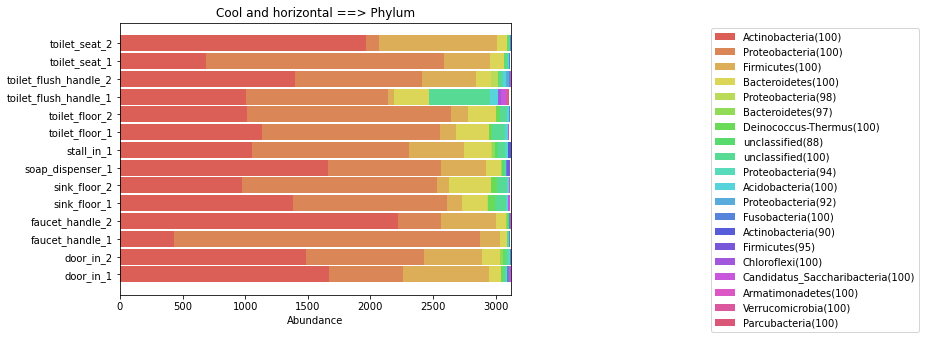

In [3]:
"""
Création de differente figures
"""

"""
1er Figure : BarPlot recupère pour une Taxo donnéer 
les abondances des espèces en fonctions de leur localisation
"""
import matplotlib.pyplot as plt
import seaborn as sns

SELECTED = "Phylum" 
dicoTaxoTest = getDicoTaxo(df)
vecteurs = getNiv(SELECTED,dicoTaxoTest) 



localisation=["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

vecteursTrier = abondanceImportant(vecteurs, 10)

vecteursTaxo = vecteursTrier[0]
vecteursComptage = np.delete(vecteursTrier, (0), axis=0)
VecteursComptInverse=np.fliplr(np.rot90(vecteursComptage,3))

N=len(VecteursComptInverse[0])
ind = np.arange(N)

l_loc = []
for i in range(len(vecteursTaxo)):
    l_loc.append(VecteursComptInverse[i])

height = 0.9
fig = plt.figure(figsize=[7, 5])
bars = []
cols = sns.color_palette("hls",len(vecteursTaxo)) #COLORS
#NOTE:max colors for "colorblind" are 10, look for solution soon!
cumulated = np.zeros(len(l_loc[0]),dtype=int)
for i in range(len(vecteursTaxo)):
    if i == 0 :
        tmpbarobject = plt.barh(ind,[int(elem) for elem in l_loc[i] ], height,color=cols[i])
    else: 
        tmpbarobject = plt.barh(ind, [int(elem) for elem in l_loc[i] ],height, left=cumulated, color=cols[i]) 
    
    listeInt= [int(elem) for elem in l_loc[i] ]
    cumulated = np.add(listeInt,cumulated)
    bars.append(tmpbarobject[0])
        

plt.xlabel('Abundance') 
plt.title('Cool and horizontal ==> ' + SELECTED) 
plt.yticks(ind, (localisation)) 
# legende dehors du plot area avec: bbbox_to_anchor
plt.legend(bars, vecteursTaxo, bbox_to_anchor=(1.5, 1))  
  

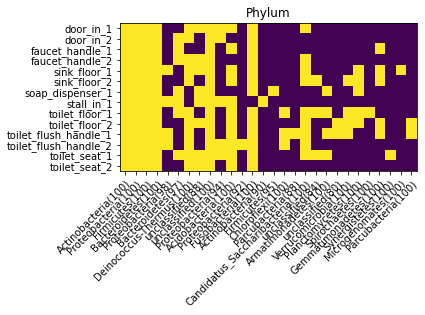

In [4]:
"""
Figure 2 : HeatMap représentant, pour un niveau de taxo donnée, 
la présence ou abscence d'une expèce dans une localisation.
"""

dicoTaxoTest = getDicoTaxo(df)
Niveau = "Phylum"
vecteurs = getNiv(Niveau,dicoTaxoTest)
mat = matrice(vecteurs)
newMat= []
for i in mat:
    listemat = []
    for j in i: 
        if j > 0:
            listemat.append(1)
        else:
            listemat.append(0)
    newMat.append(listemat)
    
localisation = ["door_in_1","door_in_2", "faucet_handle_1", 
                "faucet_handle_2", "sink_floor_1", "sink_floor_2",
               "soap_dispenser_1", "stall_in_1", "toilet_floor_1", 
               "toilet_floor_2", "toilet_flush_handle_1",
               "toilet_flush_handle_2", "toilet_seat_1", "toilet_seat_2"]

espece=vecteurs[0]
newMatInverser=np.fliplr(np.rot90(newMat,3))
matinverser=np.fliplr(np.rot90(mat,3))

fig, ax = plt.subplots()
im = ax.imshow(newMat)

ax.set_xticks(np.arange(len(espece)))
ax.set_yticks(np.arange(len(localisation)))

ax.set_xticklabels(espece)
ax.set_yticklabels(localisation)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title(Niveau)
fig.tight_layout()
plt.show()  